In [18]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import os, sys
LIB_PATH = "../src/"
sys.path.append(LIB_PATH)
from spectral_multivariate_analysis import SpectralMultivariateAnalyzer

plt.rcParams['font.size'] = 16
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.0

## シートの読み込み

In [19]:
sheet = pd.read_csv('../data/datasheet.csv', index_col=0)
sheet.head()

,path,T
sample_id,,
2,Si_In2O3_0.6.csv,0.6
4,Si_In2O3_1.6.csv,1.6
6,Si_In2O3_2.6.csv,2.6
8,Si_In2O3_3.6.csv,3.6
10,Si_In2O3_4.6.csv,4.6


## データの読み込み

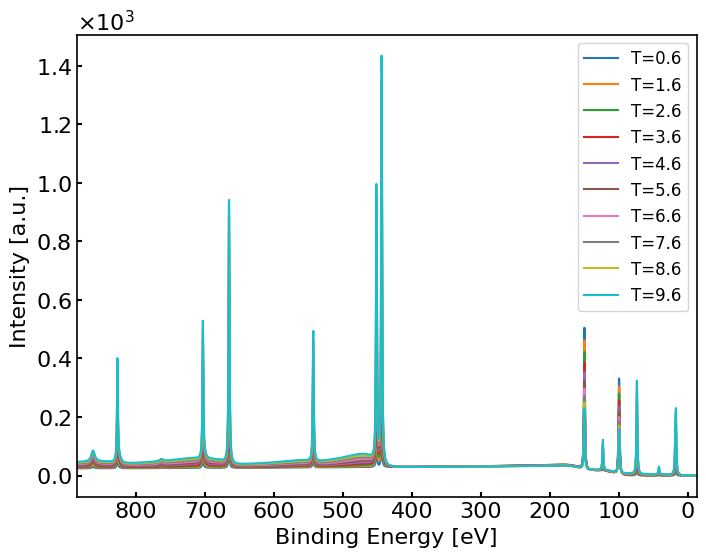

In [27]:
X = []
y = []

plt.figure(figsize=(8, 6))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(style="sci",  axis="y",scilimits=(0,0))

for index, item in sheet.iterrows():
    path = item['path']
    T = float(item['T'])
    
    spectrum = np.loadtxt(f'../data/{path}', comments='#')
    energy = -1.0 * spectrum[:, 0]; intensity = spectrum[:, 1] * 1e8
    
    plt.plot(energy, intensity, label=f"T={T}")
    
    X.append(intensity)
    y.append(T)
    
X = np.array(X)
y = np.array(y)

min_BE = np.min(energy)
max_BE = np.max(energy)

plt.xlim(max_BE, min_BE)
plt.legend(fontsize=12)
plt.xlabel('Binding Energy [eV]')
plt.ylabel('Intensity [a.u.]')

plt.show()

### 基準スペクトルの設定

In [28]:
standard = np.mean(X, axis=0)

### 多変量解析の設定

In [29]:
kwargs = {
    "X" : X,
    "y" : None,
    "standard" : standard,
    "is_scale" : True,
    "is_log_scale" : False,
    "is_sign" : True,
}
spAnalyzer = SpectralMultivariateAnalyzer(**kwargs)
result = spAnalyzer.fit(n_components=3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


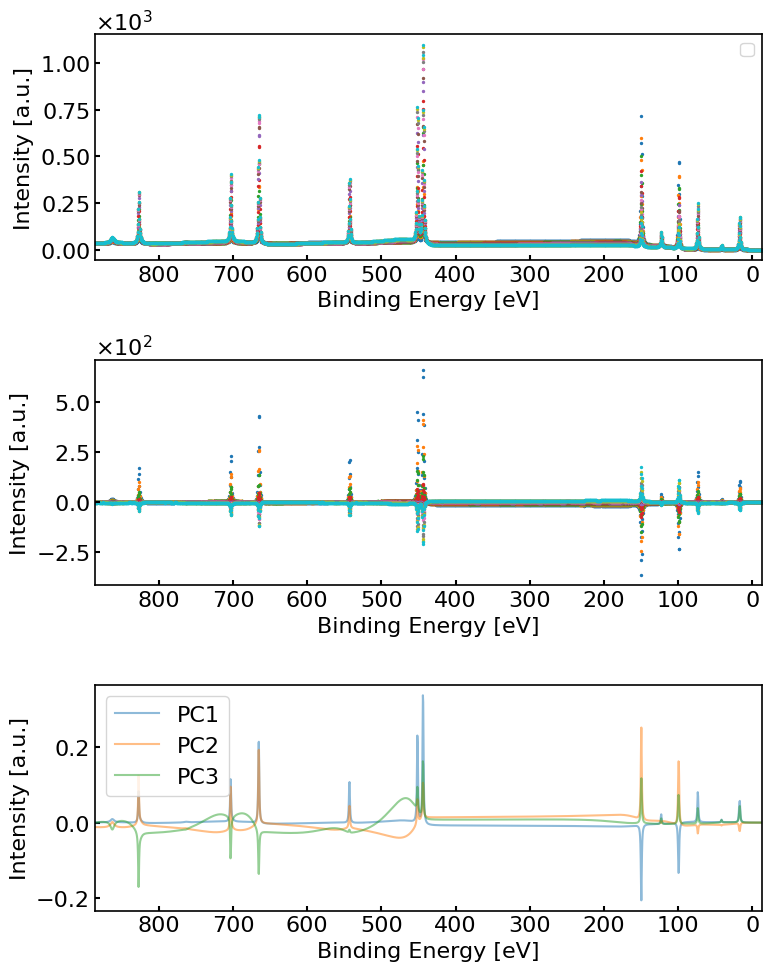

In [35]:
plt.figure(figsize=(8, 10))


plt.subplot(311)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
for i in range(spAnalyzer.X.shape[0]):
    plt.scatter(energy, spAnalyzer.X[i, :], s=2)
plt.legend(fontsize=12)

plt.xlim(max_BE, min_BE)
plt.xlabel('Binding Energy [eV]')
plt.ylabel('Intensity [a.u.]')


plt.subplot(312)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
for i in range(spAnalyzer.X.shape[0]):
    plt.scatter(energy, spAnalyzer.distance_spectrum[i, :], s=2)

plt.xlim(max_BE, min_BE)
plt.xlabel('Binding Energy [eV]')
plt.ylabel('Intensity [a.u.]')


plt.subplot(313)
for j in range(3):
    plt.plot(energy, result['H'][j, :], label=f'PC{j+1}', alpha=0.5)
    
plt.legend()
plt.xlim(max_BE, min_BE)
plt.xlabel('Binding Energy [eV]')
plt.ylabel('Intensity [a.u.]')

plt.tight_layout()
plt.show()

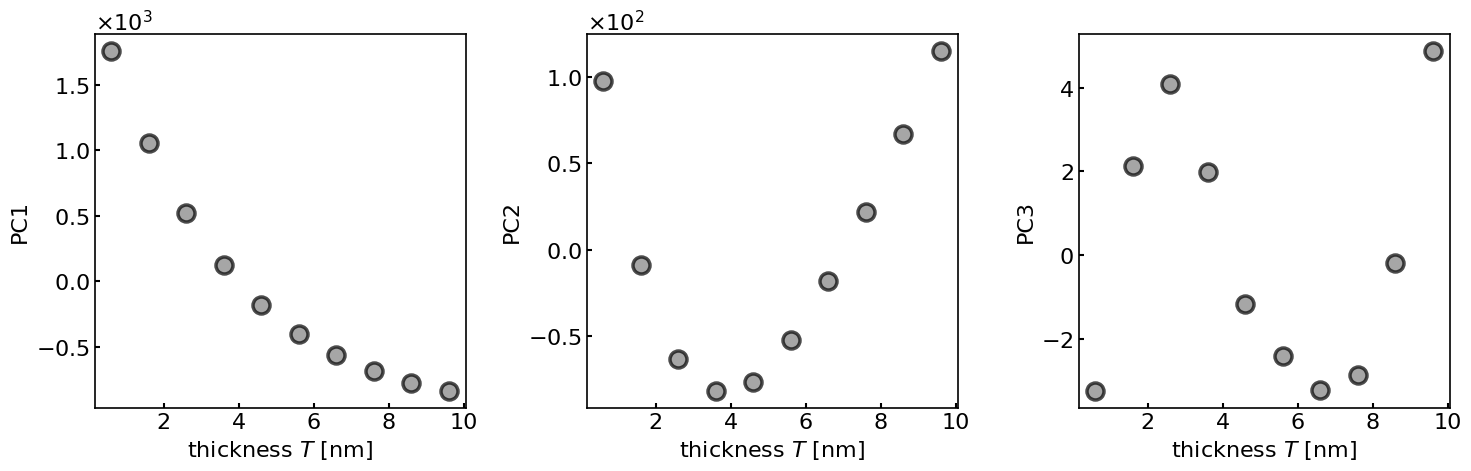

In [51]:
plt.figure(figsize=(15, 5))

n_comp = 3
for pc in range(n_comp):
    
    plt.subplot(1, n_comp, pc+1)
    plt.scatter(y, result['W'][:, pc], s=150, c='gray', edgecolor='k', lw=2.5, alpha=0.7)
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.gca().ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
    
    plt.xlabel(r'thickness $T$ [nm]');plt.ylabel(f'PC{pc+1}')

plt.tight_layout()
plt.show()

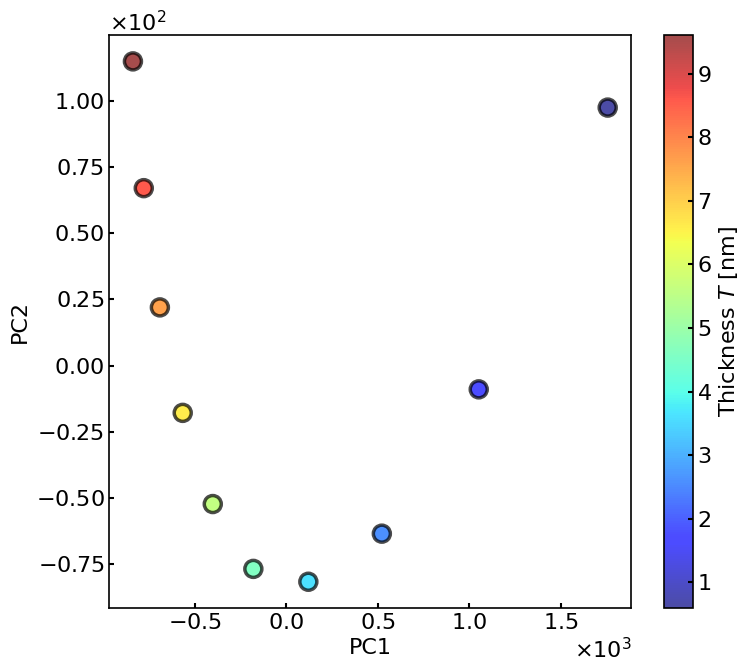

In [49]:
plt.figure(figsize=(8, 7))    
plt.scatter(result['W'][:, 0], result['W'][:, 1], s=150, c=y, edgecolor='k', lw=2.5, alpha=0.7, cmap='jet')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(style="sci",  axis="x",scilimits=(0,0))

plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(style="sci",  axis="y", scilimits=(0,0))

plt.colorbar().set_label(r'Thickness $T$ [nm]')

plt.tight_layout()
plt.show()